<a href="https://colab.research.google.com/github/ndreoo/ISBI/blob/main/MusicxMH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.15

In [ ]:
#@title Imports and Read in Data

#Importing revelant libraries and installing facets for visualisation
import pandas as pd  #gestione dati tabellari
import matplotlib.pyplot as plt
from numpy import*
from sklearn import*
import tensorflow as tf
from tensorflow import keras
import numpy as np


# sklearn encoding, data preparation and evaluation tools
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



from keras.layers import Dense, SpatialDropout3D
from keras.models import Sequential

seed = 1
# fisso il seed
np.random.seed(seed)                  #garantisce la riproducibilità degli stessi numeri casuali ad ogni esecuzione

#dimensione figure matplot
plt.rcParams["figure.figsize"] = (12,8)


#  facets
from IPython.core.display import display, HTML
import base64
!pip install --upgrade facets-overview      #scarico la versione più recente. Facets serve a fornire delle statistiche sui dati
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator


# Opening the file from github
#filename = "/content/sample_data/mxmh_survey_results.csv"
#https://raw.githubusercontent.com/ndreoo/ISBI/main/1_DataProcessing_Colab/dataset/mxmh_survey_results.csv
#https://raw.githubusercontent.com/ndreoo/ISBI/main/1_DataProcessing_Colab/dataset/mxmh_survey_results.csv
filename ="https://raw.githubusercontent.com/ndreoo/ISBI/main/1_DataProcessing_Colab/dataset/mxmh_survey_results.csv"

data = pd.read_csv(filename)            #creo un dataframe leggendo un csv tramite pandas

# replacing blank spaces with '_'       #Questa operazione serve, in quanto le query tramite Pandas non funzionano per le colonne in cui sono presenti spazi
#data.columns = [column.replace(" ", "_") for column in data.columns]
del data['Permissions']
del data['Timestamp']
data.describe()



In [ ]:
#@title Visualize the Data in Facets

# Create instance of FSG --> Serve per generare statistiche sui dati
fsg = FeatureStatisticsGenerator()

#Select dataframe
dataframes = [
    {'table': data, 'name': 'trainData'}]
censusProto = fsg.ProtoFromDataFrames(dataframes)

#Serialise
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")

#Select template
HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""

#Query and display
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

#  **Risultati prima analisi con Facets**


1.   La maggior parte delle persone che hanno aderito al sondaggio hanno un 'età compresa tra i 15 e i 25 anni. Non a caso il valore 'mean' per la feature age è 24.
2.  L'andamento della Depression è molto simile a quello della feature Anxiety. Potremmo dimostrare ciò anche con una matrice di correlazione (vedere di seguito).  
3.   La piattaforma di Streaming più utilizzata risulta essere Spotify
4.  Il genere preferito risulta essere il Rock.







array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Hours per day'}>],
       [<Axes: title={'center': 'Anxiety'}>,
        <Axes: title={'center': 'Depression'}>],
       [<Axes: title={'center': 'Insomnia'}>,
        <Axes: title={'center': 'OCD'}>]], dtype=object)

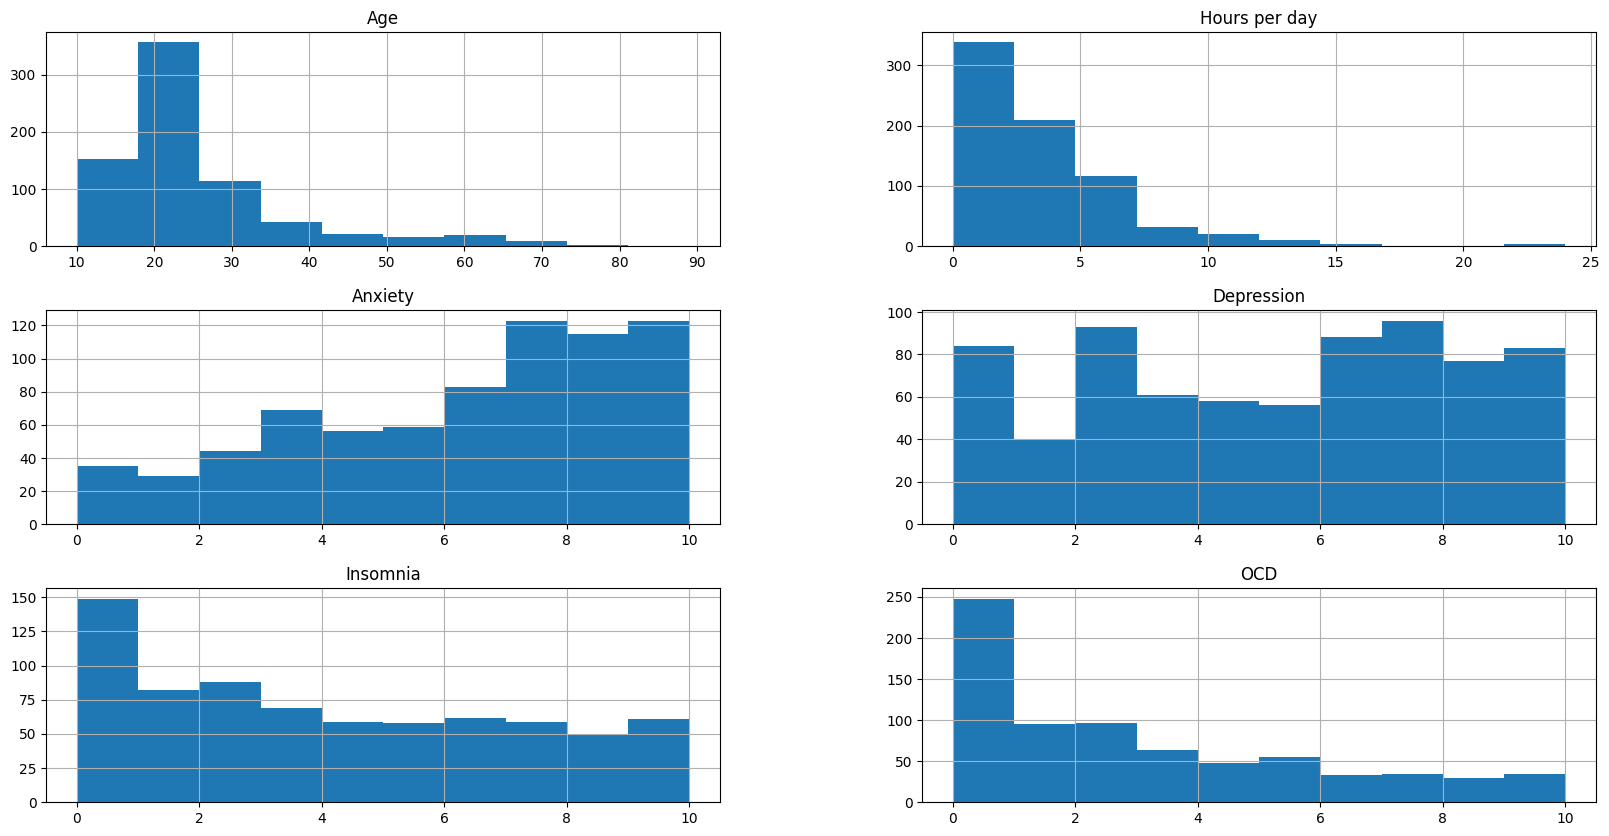

In [ ]:
# Lista delle colonne da includere nel nuovo DataFrame
columns_to_include = ['Age', 'Hours per day', 'Anxiety', 'Depression', 'Insomnia', 'OCD']

# Creazione del nuovo DataFrame 'numeric' con le colonne selezionate
numeric = data[columns_to_include].copy(deep=True)
numeric.hist(figsize=(20,10))

In [ ]:
#@title Visualize the Data - A deeper dive
SAMPLE_SIZE = 616 #@param

dive = data.sample(SAMPLE_SIZE).to_json(orient='records')

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""

html = HTML_TEMPLATE.format(jsonstr=dive)
display(HTML(html))

      Age Primary streaming service  Hours per day While working  \
0    18.0                   Spotify            3.0           Yes   
1    63.0                   Pandora            1.5           Yes   
2    18.0                   Spotify            4.0            No   
3    61.0             YouTube Music            2.5           Yes   
4    18.0                   Spotify            4.0           Yes   
..    ...                       ...            ...           ...   
731  17.0                   Spotify            2.0           Yes   
732  18.0                   Spotify            1.0           Yes   
733  19.0   Other streaming service            6.0           Yes   
734  19.0                   Spotify            5.0           Yes   
735  29.0             YouTube Music            2.0           Yes   

    Instrumentalist Composer         Fav genre Exploratory Foreign languages  \
0               Yes      Yes             Latin         Yes               Yes   
1                No    

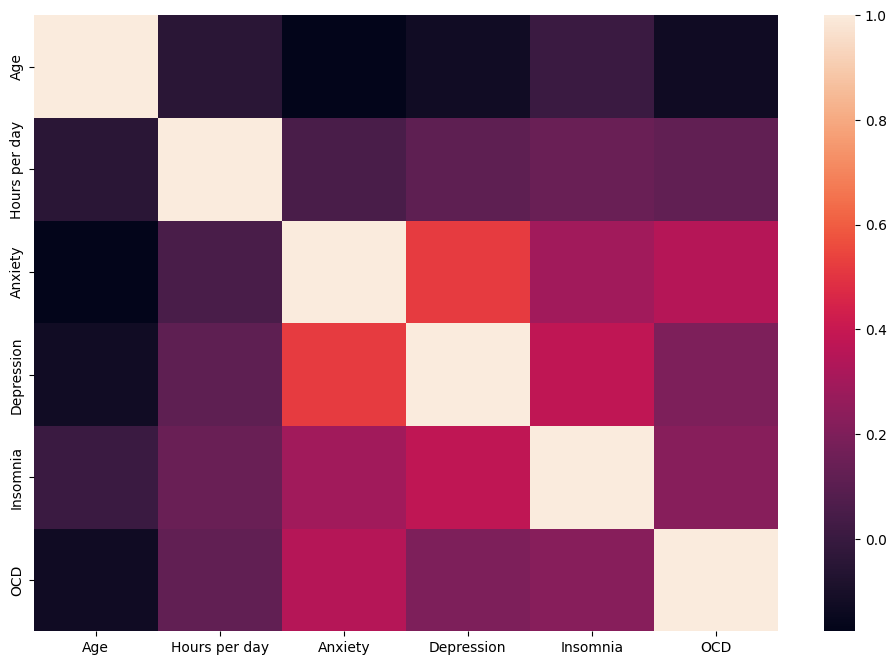

In [ ]:
import seaborn as sns


corr=numeric.corr()  # Nel caso in cui si volesse calcolare la correlazione solo per le feature numeriche
#corr= data.corr()
sns.heatmap(corr)
print(data)

# **Oversampling Dataset**
Abbiamo notato i diversi bias, proviamo a risolverne uno. Ad esempio abbiamo osservato che la maggior parte delle persone che hanno aderito al sondaggio ha un'età compresa tra i 15 ed i 25 anni. Proviamo ad effettuare un oversampling del dataset. In tal modo amplieremo una classe meno presente nel dataset (età superiore ai 40) per provare a bilanciarlo.


In [ ]:
import pandas as pd
from sklearn.utils import resample

# Carica il file CSV
#df = pd.read_csv('/path/to/mxmh_survey_results.csv')

# Separa il dataset in due gruppi: età <= 40 e età > 40
df_below_40 = data[data['Age'] <= 40]
df_above_40 = data[data['Age'] > 40]

# Esegue l'oversampling del gruppo con età > 40
df_above_40_oversampled = resample(df_above_40, replace=True, n_samples=2*len(df_below_40))

# Combina i due gruppi per ottenere il dataset bilanciato
balanced_df = pd.concat([df_below_40, df_above_40_oversampled])

# Stampa il numero di esempi per ogni gruppo di età
print(balanced_df['Age'].value_counts())
balanced_df.dropna(inplace=True)
# Salva il dataset bilanciato in un nuovo file CSV
balanced_df.to_csv('/content/sample_data/oversampled_dataset.csv', index=False)

#Compara col dataset originale
print("Numero di righe totali del dataset originale:", len(data))
print("Numero di righe totali del dataset bilanciato:", len(balanced_df))

Age
42.0    102
60.0     99
56.0     95
49.0     90
18.0     85
       ... 
37.0      5
40.0      5
12.0      3
10.0      1
39.0      1
Name: count, Length: 61, dtype: int64
Numero di righe totali del dataset originale: 736
Numero di righe totali del dataset bilanciato: 1577


# **Attenzione!!!**
 Ho riportato di nuovo qui il codice nel caso in cui si volessero analizzare le differenze statistiche tra il dataset originale ed il dataset oversampled!


In [ ]:
fsg1 = FeatureStatisticsGenerator()

#Select dataframe
dataframes = [{'table': balanced_df, 'name': 'trainData1'}]
censusProto = fsg1.ProtoFromDataFrames(dataframes)   #crea un proto dal dataframe fornito

#Serialise --> Questa serializzazione serve a passare il mio dataset alla pagina html, la quale sarà stampata tramite l'oggetto display
protostr1 = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")

#Select template
HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr1}";
        </script>"""

#Query and display
html = HTML_TEMPLATE.format(protostr1=protostr1)
display(HTML(html))

In [ ]:
#@title Visualize the Data - A deeper dive
SAMPLE_SIZE = 1577 #@param

dive = balanced_df.sample(SAMPLE_SIZE).to_json(orient='records')

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""

html = HTML_TEMPLATE.format(jsonstr=dive)
display(HTML(html))

In [ ]:
#Trasformazione dei valori di Depression
balanced_df['Depression'] = balanced_df['Depression'].apply(lambda x: 0 if x <= 5 else 1)
balanced_df['Music effects']= balanced_df['Music effects'].apply(lambda x: 0 if x<1 else 1)  #su 1700 record solo 2 dicono worsen
#Scambia colonne
#cols = list(balanced_df.columns)
#a, b = cols.index('Depression'), cols.index('Music effects')
#cols[b], cols[a] = cols[a], cols[b]
#balanced_df = balanced_df[cols]

print(balanced_df)

      Age  Primary streaming service  Hours per day  While working  \
2    18.0                          4            4.0              0   
4    18.0                          4            4.0              1   
5    18.0                          4            5.0              1   
6    18.0                          5            3.0              1   
7    21.0                          4            1.0              1   
..    ...                        ...            ...            ...   
456  49.0                          4            1.0              0   
567  68.0                          3            1.0              1   
703  44.0                          5            1.5              0   
486  48.0                          4            1.5              1   
305  56.0                          1            1.0              1   

     Instrumentalist  Composer  Fav genre  Exploratory  Foreign languages  \
2                  0         0         15            0                  1   
4    

In [ ]:
# Used to label encode categorical values
labelencoder = LabelEncoder()


#Adesso non ho più una matrice di 33 colonne, ma di 32. Inoltre l'ultima colonna non è più Permissions ma Depression
balanced_df.dropna(inplace=True)
print(balanced_df.describe())


# Ora si identificano le colonne che devono essere trattate con labelencoder
print("\n\nColumn Names & formatting:\n")
for col in balanced_df.columns.values.tolist():
    if balanced_df[col].dtype == "object" or balanced_df[col].dtype == "bool":
        print("{:<30}".format(col), ":", "{:<30}".format(str(balanced_df[col].dtype)) , "Formatting to LabelEncoding")
        balanced_df[col] = labelencoder.fit_transform(balanced_df[col])
    else:
        print("{:<30}".format(col), ":", "{:<30}".format(str(balanced_df[col].dtype)) , "No formatting required.")

#Convertiamo tutte le feature in numeriche in modo da poter lavorare con numpy
array = balanced_df.values


X1 = array[:,0:30]
Y1 = array[:,30]


#Normalizzare serve a ridurre la varianza
scaler = preprocessing.Normalizer().fit(X1)
X1 = scaler.transform(X1)

#
# print head post encoding
#
print("original")
balanced_df.describe()
print(Y1) #  --> Per Y mi aspetto 2 valori (0--> depr <=5, 1--> depr >5)

               Age  Primary streaming service  Hours per day  While working  \
count  1577.000000                1577.000000    1577.000000    1577.000000   
mean     43.273938                   3.115409       3.352854       0.755866   
std      18.527858                   1.564395       3.332003       0.429709   
min      10.000000                   0.000000       0.000000       0.000000   
25%      23.000000                   2.000000       1.000000       1.000000   
50%      44.000000                   4.000000       2.000000       1.000000   
75%      58.000000                   4.000000       4.000000       1.000000   
max      89.000000                   5.000000      24.000000       1.000000   

       Instrumentalist     Composer    Fav genre  Exploratory  \
count      1577.000000  1577.000000  1577.000000  1577.000000   
mean          0.277108     0.165504     9.200380     0.602410   
std           0.447712     0.371753     5.000297     0.489555   
min           0.000000     0

In [ ]:
print("normalizzata")
DX=pd.DataFrame(X1)
DX.describe()

normalizzata


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,1.577000e+03,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,...,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.0,1577.000000,1577.000000
mean,3.497324e-01,0.025906,0.026964,0.006192,0.002288,0.001472,0.073870,0.005032,0.003641,0.899259,...,0.007613,0.015322,0.011712,0.008606,0.016148,0.006304,0.040862,0.0,0.030265,0.016559
std,1.776345e-01,0.015829,0.025762,0.004101,0.003944,0.003436,0.045432,0.004516,0.004406,0.139615,...,0.008598,0.009219,0.010116,0.009295,0.009496,0.009023,0.030946,0.0,0.029734,0.022273
min,1.600000e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,2.018811e-01,0.012367,0.010093,0.004392,0.000000,0.000000,0.035644,0.000000,0.000000,0.891217,...,0.000000,0.009141,0.005215,0.000000,0.010914,0.000000,0.018691,0.0,0.006697,0.000000
50%,3.361233e-01,0.026980,0.018087,0.006843,0.000000,0.000000,0.077813,0.006444,0.000000,0.929769,...,0.006647,0.015058,0.010028,0.006851,0.015464,0.000000,0.036931,0.0,0.020530,0.009346
75%,4.366244e-01,0.036226,0.035167,0.008842,0.005445,0.000000,0.102803,0.008364,0.007277,0.968179,...,0.013352,0.020831,0.017960,0.015299,0.021659,0.010439,0.060516,0.0,0.051218,0.024371
max,9.752423e-01,0.131590,0.229332,0.032898,0.030471,0.030471,0.304714,0.032898,0.032898,1.000000,...,0.091414,0.065795,0.098693,0.098693,0.091414,0.091414,0.328976,0.0,0.278315,0.250484


# **Data Preparation**

In [ ]:

# La suddivisione viene effettuata in modo tale da mantenere la proporzione delle
#classi all'interno dei due insiemi, un processo noto come "stratificazione".
seed = 1
X_train1, X_test1, Y_train1, Y_test1  = train_test_split(X1, Y1, test_size=0.33, random_state=seed, shuffle = True, stratify=(Y1))

#Questa riga suddivide il dataset in input X1 e Y1 in un insieme di addestramento (X_train1, Y_train1)
# e un insieme di test (X_test1, Y_test1). La suddivisione avviene in modo che il 35% dei dati
# sia riservato per il test (test_size=0.35). Il parametro random_state è impostato a seed per garantire la riproducibilità dei risultati.
#shuffle = True indica di mescolare casualmente i dati prima di dividere, e stratify=(Y1)
#indica che la suddivisione deve essere stratificata rispetto ai valori della variabile di destinazione Y1, cioè,
#la proporzione delle classi in Y1 viene mantenuta anche in Y_train1 e Y_test1.
#


# Examine the class breakdown per dataset:

print("Training dataset length:", len(X_train1))
print("Testing dataset length:", len(X_test1))

class10TrainingPer = np.count_nonzero(Y_train1 == 0) / len(X_train1)
class10TestPer = np.count_nonzero(Y_test1 == 0) / len(X_test1)

class11TrainingPer = np.count_nonzero(Y_train1 == 1) / len(X_train1)
class11TestPer = np.count_nonzero(Y_test1 == 1) / len(X_test1)

print("\nPercentage of 0's in Training data: ", round(class10TrainingPer*100,2), "%")
print("Percentage of 0's in Test data    : ", round(class10TestPer*100,2), "%")
print("\nPercentage of 1's in Training data: ", round(class11TrainingPer*100,2), "%")
print("Percentage of 1's in Test data    : ", round(class11TestPer*100,2), "%")

Training dataset length: 1056
Testing dataset length: 521

Percentage of 0's in Training data:  73.96 %
Percentage of 0's in Test data    :  73.9 %

Percentage of 1's in Training data:  26.04 %
Percentage of 1's in Test data    :  26.1 %


da come si evince, grazie alla stratificazione, la percentuale di 1 e di 0 nei dati di training e di set sono pressochè identiche.

# **Task 3 - Algorithm Development**

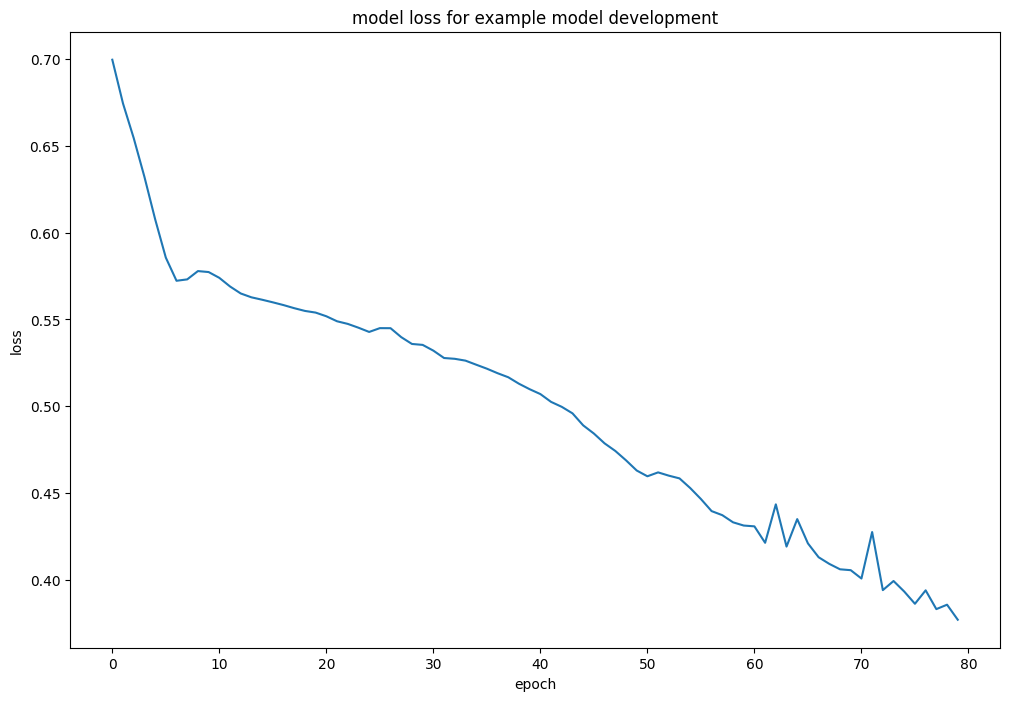

17/17 [==============================] - 0s 2ms/step - loss: 0.3916 - acc: 0.8599
Acuracy:  0.8598848581314087
17/17 [==============================] - 0s 2ms/step
Predicted    0  All
Actual             
0.0        385  385
1.0        136  136
All        521  521


In [ ]:
#@title Deep Learning Algorithm

tf.random.set_seed(seed)



modeldl = Sequential()
# Primo livello
modeldl.add(Dense(1000, input_dim=30, activation='relu'))

modeldl.add(Dense(100, activation='relu'))
modeldl.add(Dense(100, activation='relu'))
modeldl.add(Dense(50, activation='relu'))

modeldl.add(Dense(1, activation='sigmoid'))

modeldl.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])

# Qui si possono modificare i parametri del modello
results = modeldl.fit(X_train1, Y_train1, epochs=80, batch_size=1000, verbose=0)



#  Costruzione del grafico per l andamento del model loss
plt.plot(results.history['loss'])
plt.title('model loss for example model development')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

print("Acuracy: ", modeldl.evaluate(X_test1,Y_test1)[1])


#  generazione predictions
dl_y_pred = modeldl.predict(X_test1)
dl_y_pred = np.argmax(dl_y_pred,axis=1)


# Confusion Matrix:
print(pd.crosstab(Y_test1, dl_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))

In [ ]:
#@title Decision Tree algorithm

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

modeldt = DecisionTreeClassifier(max_depth=6)

modeldt.fit(X_train1, Y_train1)

results = modeldt.score(X_test1, Y_test1)

print(results)

# Generate predictions from text data
dt_y_pred = modeldt.predict(X_test1)

# Confusion Matrix:
# overall TP, FP, TN, FN values, for binary values only
print(pd.crosstab(Y_test1, dt_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))

# print the decision tree rules:
print("\n\nDecision Tree Rules:")
print("*"*40)
text_representation = tree.export_text(modeldt)
print(text_representation)


with open("newModelData.log", "w") as newfile:
  newfile.write(text_representation )

0.8733205374280231
Predicted  0.0  1.0  All
Actual                  
0.0        357   28  385
1.0         38   98  136
All        395  126  521


Decision Tree Rules:
****************************************
|--- feature_26 <= 0.02
|   |--- feature_3 <= 0.01
|   |   |--- feature_24 <= 0.02
|   |   |   |--- feature_9 <= 0.94
|   |   |   |   |--- class: 1.0
|   |   |   |--- feature_9 >  0.94
|   |   |   |   |--- feature_8 <= 0.00
|   |   |   |   |   |--- feature_9 <= 0.98
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- feature_9 >  0.98
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- feature_8 >  0.00
|   |   |   |   |   |--- feature_3 <= 0.01
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- feature_3 >  0.01
|   |   |   |   |   |   |--- class: 1.0
|   |   |--- feature_24 >  0.02
|   |   |   |--- feature_18 <= 0.00
|   |   |   |   |--- class: 1.0
|   |   |   |--- feature_18 >  0.00
|   |   |   |   |--- class: 0.0
|   |--- feature_3 >  0.01
| 

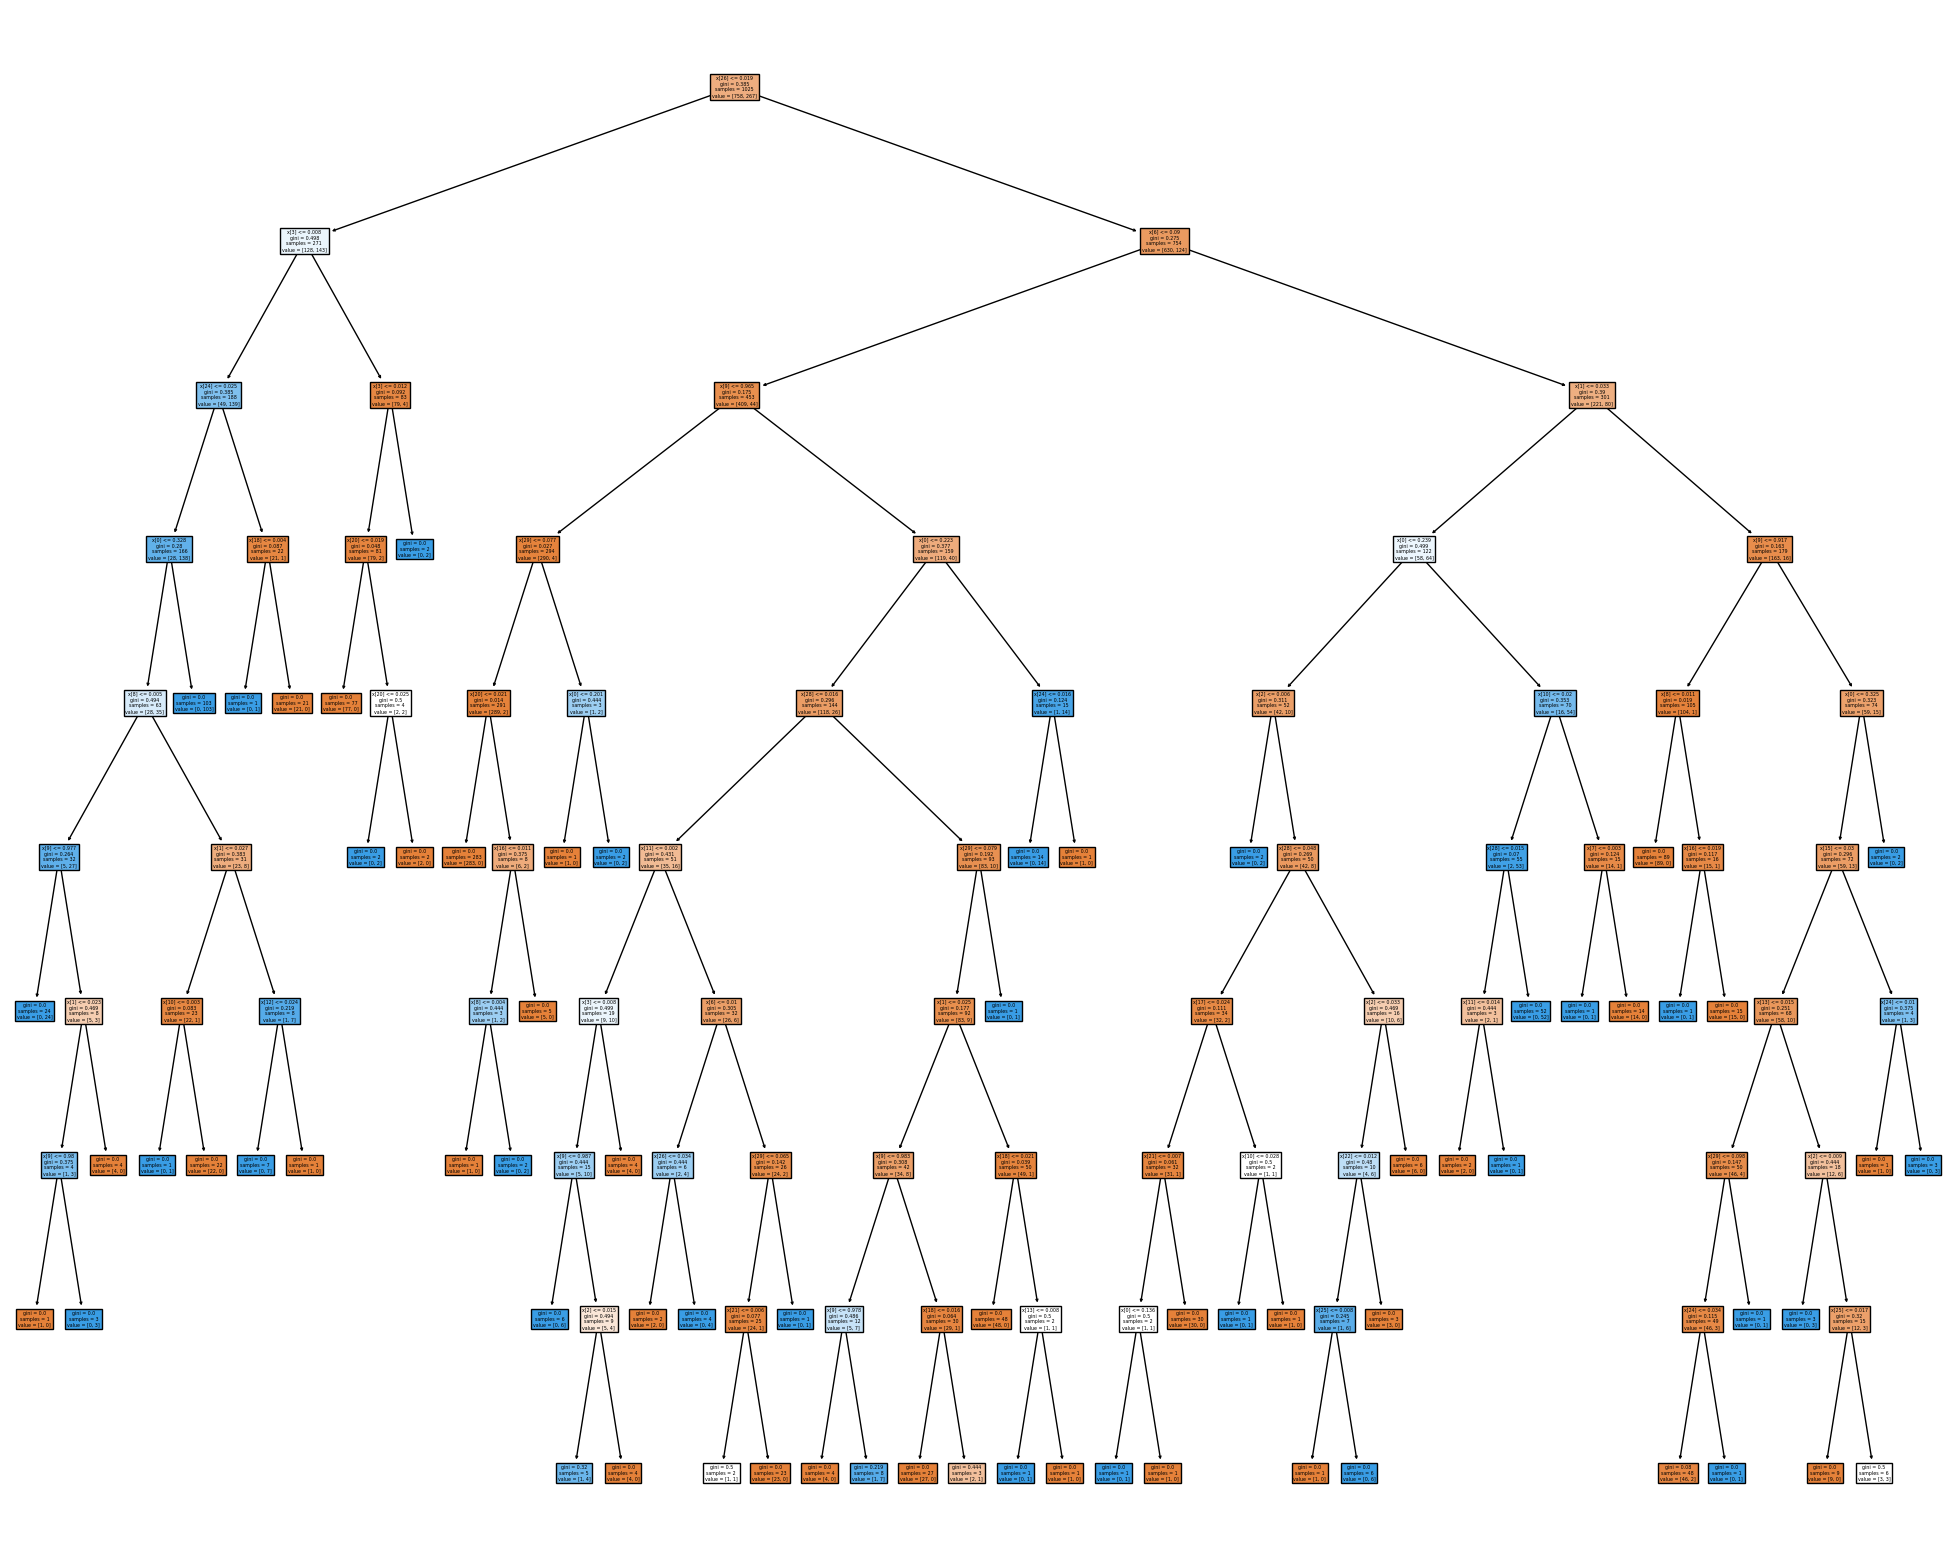

In [ ]:
fig= plt.figure(figsize=(25,20))
output= tree.plot_tree(modeldt, filled=True)

# **Task 4- Scelta dell'algoritmo (metrics)**
In base alle performance e alle metriche di confusione, scelgo l'algoritmo decision tree.

In [ ]:
#@title Definition to provide the metrics
def subMetrics(targetGroup, act, pred):
  print("Metrics for: ", targetGroup)
  correct = 0
  act = np.array(act)
  pred = np.array(pred)

  for index, item in enumerate(act):
    if item == pred[index]:
      correct += 1
  accuracy = round((correct / len(act)) * 100,2)
  return accuracy

In [ ]:



NOdepr_pred = []           # No depression -  was label encoded as 0
NOdepr_actual_class = []


YESdepr_pred = []         # Depression was label encoded as 1
YESdepr_actual_class = []


#Depression is labeled 28

# La colonna Depression è la numero 28
for index,row in enumerate(X_test1):
    if row[28] == 0:       # No depress
        NOdepr_pred.append(dt_y_pred[index])
        NOdepr_actual_class.append(Y_test1[index])
    else:     #  Depress
        YESdepr_pred.append(dt_y_pred[index])
        YESdepr_actual_class.append(Y_test1[index])


# Print the representation of each target group
print("(No) depressed instances in the test set:", len(NOdepr_pred))
print("(Yes) depressed instances in the test set:  ", len(YESdepr_pred))


print("\n"*2)
# Confusion Matrix:
# overall TP, FP, TN, FN values, for binary values only
ACC=subMetrics("NO DEP", NOdepr_actual_class, NOdepr_pred)


print("Accuracy:", ACC, "%")
print("\n")
print(pd.crosstab( np.array(NOdepr_actual_class),  np.array(NOdepr_pred), rownames=['Actual'], colnames=['Predicted'], margins=True))

print("\n")
print("\n")
print("\n")
print("\n")
print("\n")

ACC_M=subMetrics("YES DEP", YESdepr_actual_class, YESdepr_pred)
print("Accuracy:", ACC_M, "%")
print("\n")
print(pd.crosstab( np.array(YESdepr_actual_class),  np.array(YESdepr_pred), rownames=['Actual'], colnames=['Predicted'], margins=True))


(No) depressed instances in the test set: 115
(Yes) depressed instances in the test set:   406



Metrics for:  NO DEP
Accuracy: 83.48 %


Predicted  0.0  1.0  All
Actual                  
0.0         66   13   79
1.0          6   30   36
All         72   43  115










Metrics for:  YES DEP
Accuracy: 88.42 %


Predicted  0.0  1.0  All
Actual                  
0.0        291   15  306
1.0         32   68  100
All        323   83  406


Il bias algoritmico che ho voluto analizzare è il seguente:
Non posso comprendere in base all'effetto della musica (soggettivo) se una persona si ritiene depressa oppure no, per diverse ragioni. La prima è che la colonna Music Effects non si riferisce a nessuna delle patologie in particolari. Un qualsiasi utente potrebbe non essere depresso ma inserire un valore 'Improve' riferito ad esempio all'ansia o all' OCD. L'accuracy apparantemente elevata, non è considerabile ottima se l'analisi fosse fatta su dati più sensibili e controversi come ad esempio il colore della pelle.

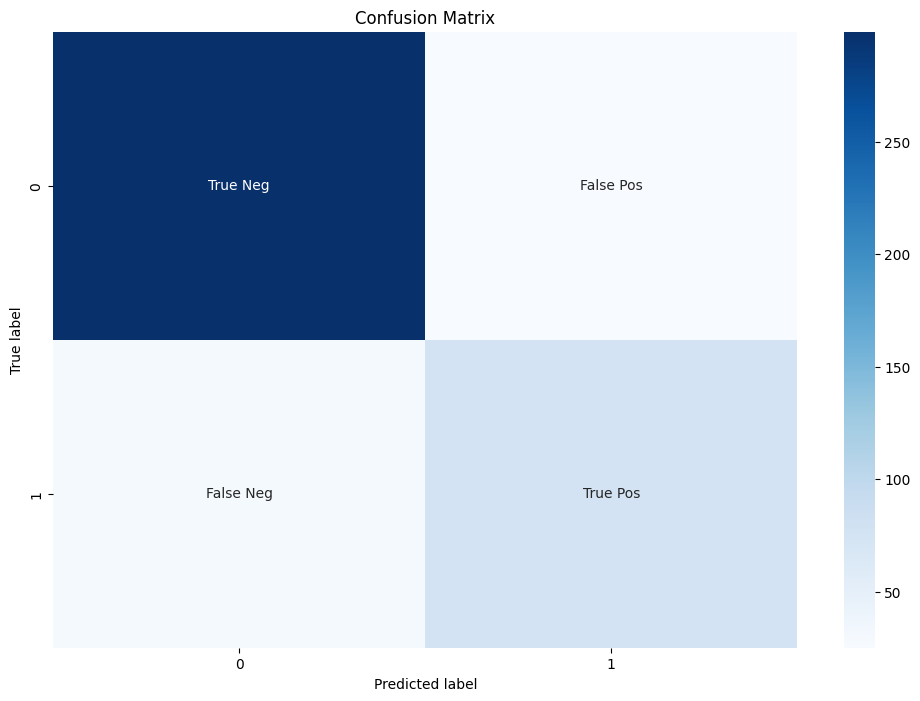

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Calcola la confusion matrix
conf_matrix = confusion_matrix(YESdepr_actual_class,YESdepr_pred)


# Create labels for the matrix
labels = ["True Neg","False Pos","False Neg","True Pos"]
labels = np.asarray(labels).reshape(2,2)

# Crea una heatmap
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')

# Creazione tabelle
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()